In [391]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
import dill
from tqdm import tqdm 
from scipy.signal import find_peaks
import sys
'''

'''

'\n\n'

In [392]:
sys.path.insert(0,'D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement')
import filter_functions as ff
                

In [393]:
# Fields pull and pull list
os.chdir('D:\OneDrive - University of Delaware - o365\Subject_Data\MatchPennies_Agent_Exp2')
PATH = os.getcwd()

analysis_pull_list = []
with open("Analysis_Pull_List.txt", "r") as file:
    analysis_pull_list = file.read().splitlines()
analysis_pull_list_reaction = [s+'_Reaction' for s in analysis_pull_list]
analysis_pull_list_timing = [s+'_Timing' for s in analysis_pull_list]
analysis_pull_list_task = [s+'_Task' for s in analysis_pull_list]

with open("Fields_Pull.txt", "r") as fields_pull:
    fields_pull = fields_pull.read().splitlines()
    
num_subjects = len(analysis_pull_list)
task_name = 'Matchpennies_Agent_Exp2'

Target information

- Row 0 = Start Target

- Row 1 = Left screen, right target x pos (left target is 2*startx - right targetx)

- Dim 1 = Radius

- Dim 2 = Thickness of the circle edge (don't know if this matters)


Dataframe is in centimeters, so need to divide everything by 100

In [394]:
file = 'Sub1_Reaction\\Sub1_ReactionTarget_Table.csv'
df = pd.read_csv(file)
df["X"] = df["X"]/100
df["Y"] = df["Y"]/100
df['Dim 1'] = df['Dim 1']/100 # Target table is in centimeters, I guess this doesn't matter but it makes me feel better
df['Dim 2'] = df['Dim 2']/100
# Target information for Right Hand (keeping this because the positions of target 3 and 4 are based on target 1 and start 1)
startx = df.loc[0]['X']
starty = df.loc[0]['Y']
start_radius = df.loc[0]['Dim 1'] 
adjusted_start_radius = start_radius*1.0 # ! This determines what size target I use to determine target leave time 

target1x = df.loc[1]['X']
target1y = df.loc[1]['Y']
target1_radius = df.loc[1]['Dim 1']

target2x = 2*startx - target1x
target2y = target1y
target2_radius = target1_radius

# Timing target
timing_targetx = startx
timing_targety = target1y
timing_target_pos = np.sqrt(timing_targetx**2 + timing_targety**2)
timing_target_radius = target1_radius   

# Parse Reaction Task Data

In [395]:
#%% Get reaction time data
block_table = pd.read_csv(f'Sub1_Reaction\\Sub1_ReactionBlock_Table.csv')
num_trials = block_table['List_Reps'].loc[0]
num_blocks = sum(~block_table['TP_LIST'].isna())
trial_time = 5000
tot_trials = int(sum(block_table['List_Reps']))

filenames = np.empty((num_subjects, num_blocks,num_trials),dtype = object)
trial_start = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
agent_reaction_decision_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
agent_reaction_decision_array = np.empty((num_subjects, num_blocks,num_trials))*np.nan

player_reaction_decision_array = np.empty((num_subjects, num_blocks,num_trials))*np.nan
player_reaction_decision_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
player_reaction_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
player_reaction_movement_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
player_reaction_plus_movement_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
player_reaction_reach_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
player_reaction_time_vel = np.zeros((num_subjects, num_blocks,num_trials))*np.nan

trial_type_array = np.zeros((num_subjects, num_blocks,num_trials))*np.nan

reaction_hand_pos_data = np.zeros((num_subjects, num_blocks,num_trials, trial_time,2))*np.nan
reaction_hand_velocity_data = np.zeros((num_subjects, num_blocks,num_trials, trial_time))*np.nan
reaction_hand_dist_data = np.zeros((num_subjects, num_blocks,num_trials, trial_time))*np.nan
reaction_hand_force_data = np.zeros((num_subjects, num_blocks,num_trials, trial_time))*np.nan


###-------------------------------------------------------------------------------------------------------
for i in range(1):
    subname = analysis_pull_list_reaction[i]
    print(i, subname)
    trial_table = pd.read_csv(subname+f'\\{subname}Trial_Table.csv')
    for x in range(tot_trials):
        block_trial_num = trial_table.iloc[x]['Block_Step']
        block_number = trial_table.iloc[x]['Block_Row']
        tp_num = trial_table.iloc[x]['TP_Row']
        j = tp_num - 1 # Block number
        k = block_trial_num - 1 # Trial number in that block
        
        filename = f"{subname}\\{task_name}_{subname}_C{block_number}_TP{tp_num}_T{block_trial_num}.csv"
        filenames[i,j,k] = filename # Store the file name
        data = pd.read_csv(filename, low_memory=False)  # Read in data
        
        
        
        #* Find the trial start time with event codes
        event_code_col = data['Event_Codes']
        if 'E_GO_TRIAL' in event_code_col.unique():
            start_time = int(data[data['Event_Codes']=='E_GO_TRIAL'].index[-1]) #! Indexed at -1 bc if they need to redo the trial, we should use the last E_GO_TRIAL, not the first 
            trial_type_array[i,j,k] = 1 
        elif 'E_SHUTOFF_TRIAL' in event_code_col.unique():
            start_time = int(data[data['Event_Codes']=='E_SHUTOFF_TRIAL'].index[-1])
            trial_type_array[i,j,k] = 0
        else:
            raise Exception('ERROR, event code not found')
            
        #* Get Reaction Time Data
        end_time = start_time + trial_time      # Find how long the trial is, constant in this case to give people time to make it
        trial_start[i,j,k] = start_time         # Store the start times, NOT THE AGENT DECISION TIMES
        agent_reaction_decision_time[i,j,k] = data.iloc[start_time]['Agent_Decision_Time'] # Store the agent go time
        cutoff_data = data.iloc[start_time:end_time] # Constrain data to the time that the trial starts, to the time that it ends
            
        reaction_hand_pos_data[i,j,k,:len(cutoff_data),:] = np.array(cutoff_data.drop(['Event_Codes'],axis=1)[['Left_HandX','Left_HandY']]) # Store left and right, slicing 3rd axis so if the trial ends early, then we just have nans at the end
        lhx = cutoff_data['Left_HandX'].to_numpy() # Left hand x position
        lhy = cutoff_data['Left_HandY'].to_numpy() # Left hand y position 
        lhx_vel = cutoff_data['Left_HandXVel'].to_numpy() # Left hand x velocity
        lhy_vel = cutoff_data['Left_HandYVel'].to_numpy() # Left hand y velocity
        lhx_force = cutoff_data['Left_FS_ForceX'].to_numpy()
        lhy_force = cutoff_data['Left_FS_ForceY'].to_numpy()
        # Filter force
        fx_nan_mask = ~np.isnan(lhx_force)
        fy_nan_mask = ~np.isnan(lhy_force)
        lhx_force_filt = np.zeros(trial_time)*np.nan
        lhy_force_filt = np.zeros(trial_time)*np.nan
        lhx_force_filt[:np.count_nonzero(fx_nan_mask)] = ff.Filter_KIN(lhx_force[fx_nan_mask])
        lhy_force_filt[:np.count_nonzero(fy_nan_mask)] = ff.Filter_KIN(lhy_force[fy_nan_mask])
        
        #* Get force, speed, dist and store them in arrays
        force = np.sqrt(lhx_force_filt**2 + lhy_force_filt**2)
        reaction_hand_force_data[i,j,k,:] = force
        speed = np.sqrt((lhx_vel)**2 + (lhy_vel)**2) # Calculate velocity
        reaction_hand_velocity_data[i,j,k,:len(speed)] = speed # Store velocity 
        dist = np.sqrt((lhx-startx)**2 + (lhy-starty)**2) # Calculate dist
        reaction_hand_dist_data[i,j,k,:len(dist)] = dist # Store dist
        

        

        q = np.argwhere(np.sqrt((lhx-target1x)**2 + (lhy-target1y)**2) < target1_radius) # Find when people enter the right target
        r = np.argwhere(np.sqrt((lhx-target2x)**2 + (lhy-target2y)**2) < target2_radius) # Find when people enter the left target
        s = np.argwhere(dist > adjusted_start_radius)  # Find when people leave the start
        t = np.argwhere(np.sqrt((lhx_vel)**2 + (lhy_vel)**2) > 0.05) # Find when people's velocity is greater than 0.05 cm/s
        
        if np.size(t)>0:
            player_reaction_time_vel[i,j,k] = t[0] - agent_reaction_decision_time[i,j,k]
        else:
            raise Exception('no velocity threshold crossed')
        if np.size(s)>0: 
            player_reaction_decision_time[i,j,k] = s[0]
            player_reaction_time[i,j,k] = s[0]  - agent_reaction_decision_time[i,j,k]
            
            #TODO Check lower threshold of speed up to the time that they leave the target to get the true decision time 
            
        else:
            raise Exception('no position threshold crossed')
        if np.size(q)>0: #if LH enters right target
            player_reaction_decision_array[i,j,k] = 1
            player_reaction_movement_time[i,j,k] = q[0] - s[0]
            player_reaction_plus_movement_time[i,j,k] = q[0] - agent_reaction_decision_time[i,j,k]
            
        elif np.size(r)>0: #if LH enters left target
            player_reaction_decision_array[i,j,k] = -1   
            player_reaction_movement_time[i,j,k] = r[0] - s[0]
            player_reaction_plus_movement_time[i,j,k] = r[0] - agent_reaction_decision_time[i,j,k]          
            
        # #plot path for Reactions
        if False:
            # for i in range(1):
            # plot_end_time = int(agent_reaction_decision_time[i,j,k] + player_reaction_time[i,j,k])
            # plot_end_time = int(start_time + 500)
            lhx_new = np.array(data.iloc[start_time:int(start_time+s[0][0])]['Left_HandX'])
            lhy_new = np.array(data.iloc[start_time:int(start_time+s[0][0])]['Left_HandY'])
            # plt.figure(dpi=300)
            # circleR = plt.Circle((target1x,target1y), target1_radius, color = 'r', fill = False)
            # circleL = plt.Circle((target2x,target2y), target2_radius, color = 'r', fill = False)
            # startCirc = plt.Circle((startx,starty), start_radius, color = 'r', fill = False)
            # fig, ax = plt.subplots()
            # ax.add_patch(circleR)
            # ax.add_patch(circleL)
            # ax.add_patch(startCirc)
            # plt.plot(lhx,lhy) 
            # plt.show()
            # plt.scatter(lhx_new[int(s[0])], lhy_new[int(s[0])])
            # print(player_reaction_time[i,j,k])
            # plt.title("w =%1.0f " %i + "x=%1.0f "%j + "c=%1.0f"%k + 'vely=%1.5f'%vel_check)
            fig,ax = plt.subplots()
            hand_dist = np.sqrt((lhx-startx)**2 + (lhy-starty)**2)
            plt.plot(hand_dist)
            plt.scatter(s[0],hand_dist[int(s[0])])
            plt.plot(speed)
            
            plt.scatter(t[0],speed[int(t[0])])
            plt.show()

 
 

0 Sub8_Reaction


In [401]:
##
#* Align each of the force profiles with when the agent goes
reaction_hand_force_data_start_when_agent_goes = np.zeros_like(reaction_hand_force_data)
for i in range(num_subjects):
    for j in range(num_blocks):
        for k in range(num_trials):
            if np.isnan(agent_reaction_decision_time[i,j,k]):
                break
            x = int(agent_reaction_decision_time[i,j,k])
            reaction_hand_force_data_start_when_agent_goes[i,j,k,:] = np.roll(reaction_hand_force_data[i,j,k,:],-x)
            reaction_hand_force_data_start_when_agent_goes[i,j,k,-x:] = np.nan
#* Get average across all trials for each subject, each block
mean_force = np.nanmean(reaction_hand_force_data_start_when_agent_goes,axis=(2))

#* Find max peak in average signal and find 0.25 and 0.75 of the averaged force values
max_mean_force = np.nanmax(mean_force,axis=(2))
index_mean_force = np.nanargmax(mean_force,axis=2)
max25 = 0.25*max_mean_force
max75 = 0.75*max_mean_force
max25_timepoint = np.zeros((num_subjects,num_blocks))
max75_timepoint = np.zeros_like(max25_timepoint)
for i in range(num_subjects):
    for j in range(num_blocks):
        a,_ = min(enumerate(mean_force[i,j,:index_mean_force[i,j]]), key=lambda x: abs(x[1]-max25[i,j])) # Enumerate mean force to get timepoint and value, only slice up to the max value, then find where it's closest to 25percent of max value
        max25_timepoint[i,j] = a
        b,_ = min(enumerate(mean_force[i,j,:index_mean_force[i,j]]), key=lambda x: abs(x[1]-max75[i,j]))
        max75_timepoint[i,j] = b

#* Draw line and find where it intersects 0
x1vals = max25_timepoint
x2vals = max75_timepoint
y1vals = max25
y2vals = max75
slopes = (y2vals - y1vals)/(x2vals - x1vals)
intercepts = y2vals - slopes*x2vals
time_at_zero = -intercepts/slopes
player_reaction_time_force = time_at_zero

shutoff_mask = trial_type_array == 0
go_mask = trial_type_array == 1
player_shutoff_reaction_time = player_reaction_time*shutoff_mask     
player_shutoff_reaction_time[~shutoff_mask] = np.nan      
player_go_reaction_time = player_reaction_time*go_mask          
player_go_reaction_time[~go_mask] = np.nan     
        

C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_33060\376989752.py:13: RuntimeWarning: Mean of empty slice
  mean_force = np.nanmean(reaction_hand_force_data_start_when_agent_goes,axis=(2))


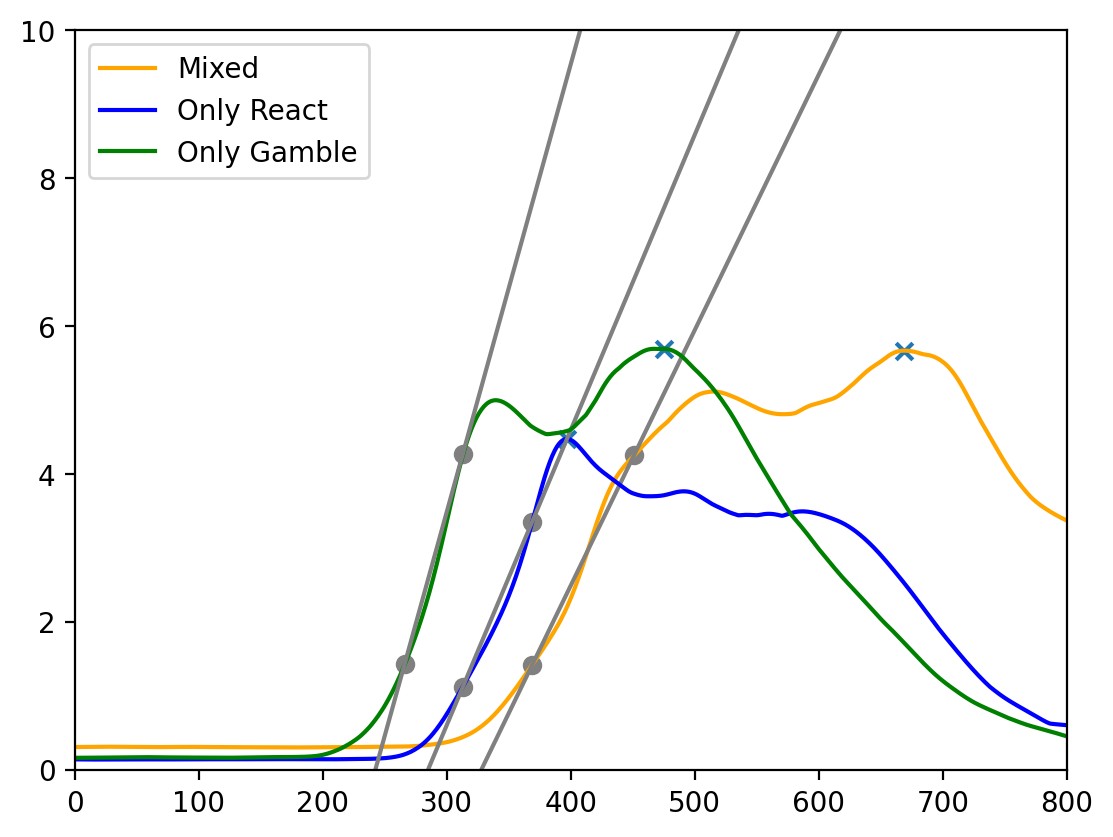

In [412]:
x1 = mean_force[0,0,:]
x2 = mean_force[0,1,:]
x3 = mean_force[0,2,:]
fig,ax = plt.subplots(dpi=200)
x1line = slopes[0,0]*np.arange(0,len(x1)) + intercepts[0,0]
x2line = slopes[0,1]*np.arange(0,len(x2)) + intercepts[0,1]
x3line = slopes[0,2]*np.arange(0,len(x3)) + intercepts[0,2]

ax.plot(np.arange(0,len(x1)),x1,c ='orange',label='Mixed')
ax.scatter(max25_timepoint[0,0],max25[0,0],c='grey')
ax.scatter(max75_timepoint[0,0],max75[0,0],c='grey')
ax.plot(x1line,c='grey')

ax.plot(np.arange(0,len(x2)),x2,c='blue',label='Only React')
ax.scatter(max25_timepoint[0,1],max25[0,1],c='grey')
ax.scatter(max75_timepoint[0,1],max75[0,1],c='grey')
ax.plot(x2line,c='grey')

ax.plot(np.arange(0,len(x3)),x3,'green',label='Only Gamble')
ax.scatter(max25_timepoint[0,2],max25[0,2],c='grey')
ax.scatter(max75_timepoint[0,2],max75[0,2],c='grey')
ax.plot(x3line,c='grey')

ax.scatter(index_mean_force[0,:],max_mean_force[0,:],marker='x')

ax.set_ylim(0,10)
ax.set_xlim(0,800)
ax.legend()
plt.show()

In [413]:
player_reaction_time_force

array([[328. , 285. , 242.5]])

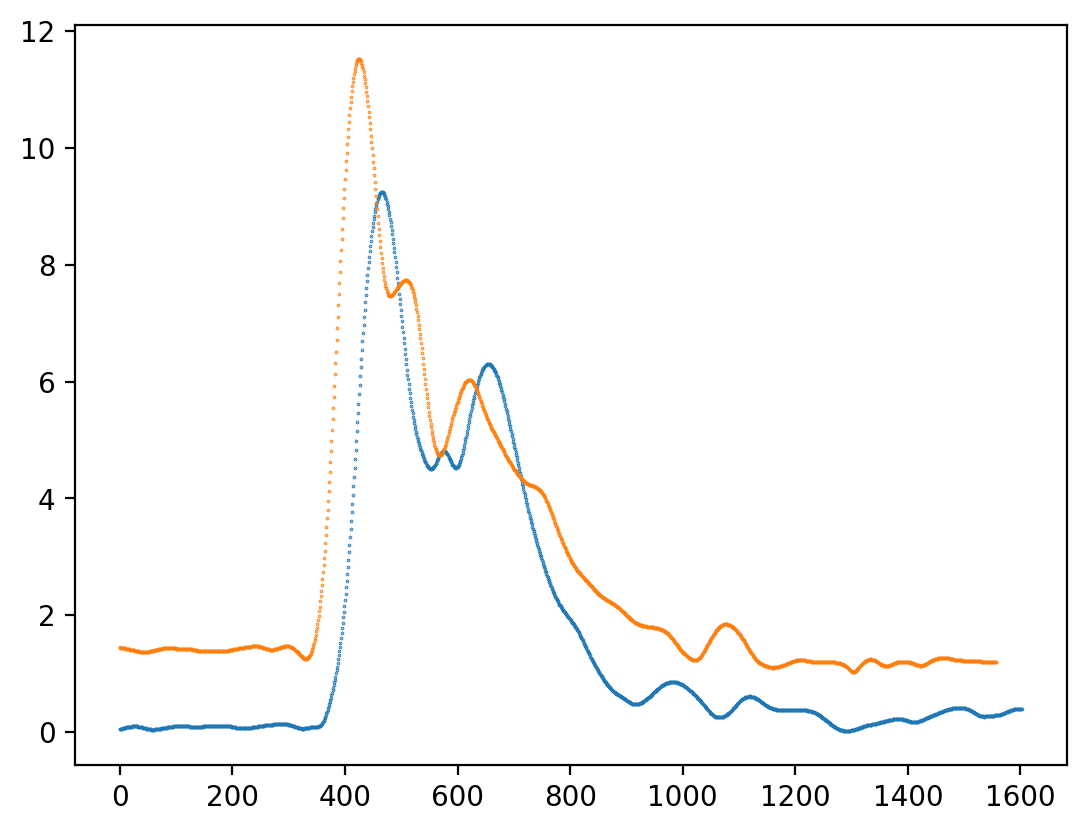

In [398]:
x1 = hand_force_data_start_when_agent_goes[0,0,40,:]
x2 = hand_force_data_start_when_agent_goes[0,0,39,:]
fig,ax = plt.subplots(dpi=200)
# # ax.scatter(np.arange(0,len(lhx_force)),lhx_force,s=0.1)
# ax.axvline(agent_reaction_decision_time[0,0,1])
# ax.axvline(agent_reaction_decision_time[0,0,3])
ax.scatter(np.arange(0,len(x1)),x1,s=0.1)
ax.scatter(np.arange(0,len(x2)),x2+1,s=0.1,)
# ax.scatter(np.arange(0,len(lhx_force_filt)),hand_force_data[-1,-1,-1,:])
plt.show()


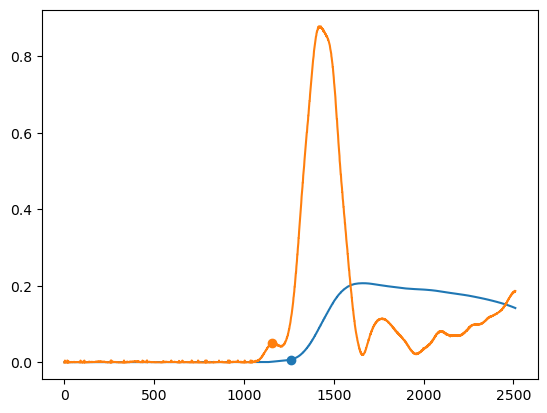

In [399]:
i,j,k = 0,0,1
lhx = hand_pos_data[i,j,k,:,0]
lhy = hand_pos_data[i,j,k,:,1]
hand_dist = np.sqrt((lhx-startx)**2 + (lhy-starty)**2)
rt = player_reaction_time[i,j,k] + agent_reaction_decision_time[i,j,k]

speed = hand_velocity_data[i,j,k,:] 
rt_vel = player_reaction_time_vel[i,j,k] + agent_reaction_decision_time[i,j,k]

fig,ax = plt.subplots()

plt.plot(hand_dist)
plt.scatter(rt,hand_dist[int(rt)])
plt.plot(speed)
plt.scatter(rt_vel,speed[int(rt_vel)])
plt.show()

Extrapolation method for determining reaction times

In [400]:
agent_reaction_decision_time.shape
hand_dist_data[...,agent_reaction_decision_time]

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
hand_dis_data_start_when_agent_goes = np.zeros_like(hand_dist_data)*np.nan
nan_mask = np.isnan(agent_reaction_decision_time)
agent_reaction_decision_time[nan_mask] = 0
for i in range(num_subjects):
    for j in range(num_blocks):
        for k in range(num_trials):
            if np.isnan(agent_reaction_decision_time[i,j,k]):
                hand_dis_data_start_when_agent_goes[i,j,k,:] = np.nan 
            else:
                length = len(hand_dist_data[i,j,k,int(agent_reaction_decision_time[i,j,k]):])
                hand_dis_data_start_when_agent_goes[i,j,k,:length] = hand_dist_data[i,j,k,int(agent_reaction_decision_time[i,j,k]):]
        

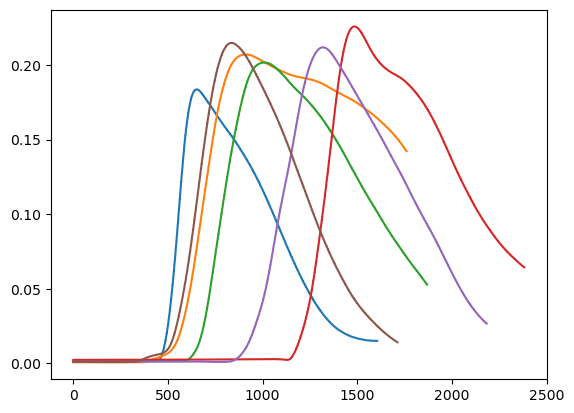

In [ ]:
plt.plot(np.arange(0,len(hand_dis_data_start_when_agent_goes[0,0,12,:]),1),hand_dis_data_start_when_agent_goes[0,0,12,:])
plt.plot(np.arange(0,len(hand_dis_data_start_when_agent_goes[0,0,1,:]),1),hand_dis_data_start_when_agent_goes[0,0,1,:])
plt.plot(np.arange(0,len(hand_dis_data_start_when_agent_goes[0,0,2,:]),1),hand_dis_data_start_when_agent_goes[0,0,2
                                                                                                              ,:])
plt.plot(np.arange(0,len(hand_dis_data_start_when_agent_goes[0,0,3,:]),1),hand_dis_data_start_when_agent_goes[0,0,3,:])
plt.plot(np.arange(0,len(hand_dis_data_start_when_agent_goes[0,0,4,:]),1),hand_dis_data_start_when_agent_goes[0,0,4,:])
plt.plot(np.arange(0,len(hand_dis_data_start_when_agent_goes[0,0,5,:]),1),hand_dis_data_start_when_agent_goes[0,0,5,:])

In [ ]:
# Create yn+1 and yn-1 
hand_dist_plus_one = np.roll(hand_dis_data_start_when_agent_goes,1,axis=3)
hand_dist_plus_one[...,0] = np.nan # Set the rolled data point to nan (first one in this case)

hand_dist_minus_one = np.roll(hand_dis_data_start_when_agent_goes,-1,axis=3)
hand_dist_minus_one[...,-1] = np.nan # Set the rolled data point to nan (last one in this case)

# Sampling interval 
sampling_interval = 1000

#* Get acceleration from position 
acc = (hand_dist_plus_one - 2*hand_dis_data_start_when_agent_goes + hand_dist_minus_one)/sampling_interval
#* Average all the force signals across all trials
avg_acc_signal = np.nanmean(acc,axis=2)
#* Find peak in average signal

#* find 0.25 and 0.75 of the averaged force values

#* Draw line and find where it intersects 0



C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_35084\2341909865.py:14: RuntimeWarning: Mean of empty slice
  avg_acc_signal = np.nanmean(acc,axis=2)


# Pickle Reaction Stuff

In [ ]:
i=-1
for subname in analysis_pull_list:
    i+=1
    data_path = f'Subjects_Analyzed\\{subname}\\'
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    print(subname)
    print(data_path)
    dill.dump(player_reaction_time[i,:,:], open(data_path + f'{subname}_player_reaction_time.pkl', 'wb'))
    dill.dump(player_reaction_movement_time[i,:,:], open(data_path + f'{subname}_player_reaction_movement_time.pkl', 'wb'))
    dill.dump(player_reaction_plus_movement_time[i,:,:], open(data_path + f'{subname}_player_reaction_plus_movement_time.pkl', 'wb'))
    dill.dump(player_reaction_decision_array[i,:,:], open(data_path + f'{subname}_player_reaction_decision_array.pkl', 'wb'))
    dill.dump(agent_reaction_decision_array[i,:,:], open(data_path + f'{subname}_agent_reaction_decision_array.pkl', 'wb'))
    dill.dump(agent_reaction_decision_time[i,:,:], open(data_path + f'{subname}_agent_reaction_decision_time.pkl', 'wb'))
    dill.dump(trial_type_array[i,:,:], open(data_path + f'{subname}_reaction_trial_type_array.pkl', 'wb'))
    
    # dill.dump(agent_decision_time[i,:], open(data_path + f'{subname}_agent_decision_time.pkl', 'wb'))


Sub8
Subjects_Analyzed\Sub8\


# Parse Timing Data

In [ ]:
coincidence_trial_time = 2500
coincidence_trials = 50
coincidence_trial_start = np.zeros((num_subjects, coincidence_trials))*np.nan
coincidence_reach_time = np.zeros((num_subjects, coincidence_trials))*np.nan

interval_trial_time = 2500
interval_trials = 50
interval_trial_start = np.zeros((num_subjects, interval_trials))*np.nan
interval_reach_time =  np.zeros((num_subjects, interval_trials))*np.nan

control_trials = interval_trials + coincidence_trials
###-------------------------------------------------------------------------------------------------------
for i in range(num_subjects):
    sub_name = analysis_pull_list_timing[i]
    print(i, sub_name)
    file = f'{sub_name}\\{sub_name}Trial_Table.csv'
    control_trial_table = pd.read_csv(file)
    block_number = 1
    tp_num = 1
    for x in ((range(control_trials))):
        block_number = control_trial_table.iloc[x]['Block_Row']
        tp_num = control_trial_table.iloc[x]['TP_Row']
        block_trial_num = control_trial_table.iloc[x]['Block_Step']
        filename = f'{sub_name}\\{task_name}_{sub_name}_C{block_number}_TP{tp_num}_T{block_trial_num}.csv'
        j = tp_num - 1 # Block number
        k = block_trial_num - 1 # Trial number in that block
        data = pd.read_csv(filename, low_memory=False)
        # if 'Agent_Initial_Time' in data.columns:
        #     data = data.rename(columns = {'Agent_Inital_Time':'Agent_Decision_Time'}, inplace=True)
        # f = data['Agent_Decision_Time']
        start_time = int(data[data['Event_Codes']=='E_SOUND_SIGNAL'].index[0])
        # Get Interval Timing Data
        if tp_num == 1:
            end_time = start_time + interval_trial_time
            interval_trial_start[i,k] = start_time # Store start time
            lhx = np.array(data.iloc[start_time:end_time]['Left_HandX'])
            lhy = np.array(data.iloc[start_time:end_time]['Left_HandY'])
            q = np.argwhere(np.sqrt((lhx-timing_targetx)**2 + (lhy-timing_targety)**2) < timing_target_radius) # THIS NEEDS TO BE THE CENTER TARGET... x poisition should be the start
            if np.size(q)>0:
                interval_reach_time[i,k] = q[0]
        # Get Coincidence Timing Data
        if tp_num == 2:
            end_time = start_time + coincidence_trial_time
            coincidence_trial_start[i,k] = start_time # Store start time
            lhx = np.array(data.iloc[start_time:end_time]['Left_HandX'])
            lhy = np.array(data.iloc[start_time:end_time]['Left_HandY'])
            q = np.argwhere(np.sqrt((lhx-timing_targetx)**2 + (lhy-timing_targety)**2) < timing_target_radius) # THIS NEEDS TO BE THE CENTER TARGET... x poisition should be the start
            if np.size(q)>0:
                coincidence_reach_time[i,k] = q[0] 
                
            # #plot path for Reactions
            if False:
                for i in range(1):
                    player_reaction_time[0,0] = 500
                    plot_end_time = int(start_time + player_reaction_time[i,k])
                    # plot_end_time = int(start_time + 500)
                    lhx_new = np.array(data.iloc[start_time:int(plot_end_time)]['Left_HandX'])
                    lhy_new = np.array(data.iloc[start_time:int(plot_end_time)]['Left_HandY'])
                    plt.figure(dpi=300)
                    circleR = plt.Circle((target1x,target1y), target1_radius, color = 'r', fill = False)
                    circleL = plt.Circle((target2x,target2y), target2_radius, color = 'r', fill = False)
                    startCirc = plt.Circle((startx,starty), start_radius, color = 'r', fill = False)
                    fig, ax = plt.subplots()
                    ax.add_patch(circleR)
                    ax.add_patch(circleL)
                    ax.add_patch(startCirc)
                    plt.plot(lhx_new,lhy_new) 
                    # plt.scatter(lhx_new[int(s[0])], lhy_new[int(s[0])])
                    print(player_reaction_time[i,k])
                    # plt.title("w =%1.0f " %i + "x=%1.0f "%j + "c=%1.0f"%k + 'vely=%1.5f'%vel_check)
                    plt.show()

0 Sub8_Timing


# Pickle Timing Data

In [ ]:
i=-1
for subname in analysis_pull_list:
    i+=1
    data_path = f'Subjects_Analyzed\\{subname}\\'
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    print(subname)
    print(data_path)
    dill.dump(interval_trial_start[i,:], open(data_path + f'{subname}_interval_trial_start.pkl', 'wb'))
    dill.dump(interval_reach_time[i,:], open(data_path + f'{subname}_interval_reach_time.pkl', 'wb'))
    dill.dump(coincidence_trial_start[i,:], open(data_path + f'{subname}_coincidence_trial_start.pkl', 'wb'))
    dill.dump(coincidence_reach_time[i,:], open(data_path + f'{subname}_coincidence_reach_time.pkl', 'wb'))

Sub8
Subjects_Analyzed\Sub8\


# Parse Task Data

In [ ]:
#%% Get task time task_df
# Get trials, blocks, trial_time from trial_table
path1 = PATH+'\\'+'Sub1_Task'
task_df = pd.read_csv(path1+f'\\Sub1_TaskTrial_Table.csv')
task_df = task_df.loc[task_df['Condition type']==3] # Only get the task condition 
num_trials = int(task_df.iloc[-1]['Block_Step']) # number of trials in each block
num_blocks = int(task_df.iloc[-1]['Block_Row'])
tot_trials = int(num_trials*num_blocks)
trial_time = int(task_df.iloc[0]['Condition time'])
task_df_columns = len(fields_pull)
# Need to be kept outside subject for-loop
task_trial_end = np.zeros([num_subjects, num_blocks, num_trials, 2])*np.nan
task_trial_start = np.zeros((num_subjects, num_blocks, num_trials))*np.nan
filename_storage = np.empty((num_subjects, num_blocks, num_trials), dtype=object)

task_data = np.zeros((num_subjects, num_blocks, num_trials, trial_time+500, task_df_columns))*np.nan
win_check_R = np.zeros((num_subjects, num_blocks))
win_check_L = np.zeros((num_subjects, num_blocks))
num_miss_check_R = np.zeros((num_subjects, num_blocks))
num_miss_check_L = np.zeros((num_subjects, num_blocks))
#########
player_task_decision_array = np.empty((num_subjects, num_blocks, num_trials))
player_task_reach_time = np.zeros([num_subjects, num_blocks, num_trials])*np.nan
player_task_decision_time = np.zeros([num_subjects, num_blocks, num_trials])*np.nan
player_task_movement_time = np.zeros([num_subjects, num_blocks, num_trials])*np.nan
agent_task_decision_time = np.zeros((num_subjects, num_blocks, num_trials))
agent_task_reach_time = np.zeros((num_subjects, num_blocks, num_trials))
agent_task_decision_array = np.zeros((num_subjects, num_blocks, num_trials))

###-------------------------------------------------------------------------------------------------------
for i in range(num_subjects):
    sub_name = analysis_pull_list_task[i]
    print(i, sub_name)
    path1 = PATH+'\\'+sub_name
    file = path1+f'\\{sub_name}Trial_Table.csv'
    trial_table = pd.read_csv(file)
    # Splt trial table into task and washout based on condition type
    task_trial_table = trial_table[trial_table['Condition type']==3]
    block_number = 1
    tp_num = 1
    for x in tqdm((range(tot_trials))):
        block_number = task_trial_table.iloc[x]['Block_Row']
        tp_num = task_trial_table.iloc[x]['TP_Row']
        block_trial_num = task_trial_table.iloc[x]['Block_Step']
        j = tp_num - task_trial_table['TP_Row'].min()  # Block number
        k = block_trial_num - 1 # Trial number in that block
        
        filename = PATH+f"\\{sub_name}\\{task_name}_{sub_name}_C{block_number}_TP{tp_num}_T{block_trial_num}.csv"
        task_df = pd.read_csv(filename, low_memory=False)
        start_time = int(task_df[task_df['Event_Codes']=='E_SOUND_SIGNAL'].index[0])
        end_time = start_time + trial_time + 500 # Add 500 to see when they got there when trial ended
        data_task_df = task_df.drop(columns ='Event_Codes') # Drop event codes cuz it's not number column and can't be an array 
        task_data[i,j,k,:,:] = np.array(data_task_df.iloc[start_time:end_time])

        task_trial_start[i,j,k] = start_time
        lhx = np.array(task_df.iloc[start_time:end_time]['Left_HandX'])
        lhy = np.array(task_df.iloc[start_time:end_time]['Left_HandY'])
        q = np.argwhere(np.sqrt((lhx-target1x)**2 + (lhy-target1y)**2) < target1_radius)
        r = np.argwhere(np.sqrt((lhx-target2x)**2 + (lhy-target2y)**2) < target2_radius) 
        s = np.argwhere(np.sqrt((lhx-startx)**2 + (lhy-starty)**2) > adjusted_start_radius) # Multiplied by 2 so people don't accidentally drift outside start
        
        #print(vel_check)
        agent_task_decision_time[i,j,k] = task_df.iloc[start_time+1]['Agent_Decision_Time'] 
        agent_task_reach_time[i,j,k] = agent_task_decision_time[i,j,k] + 150  
        agent_task_decision_array[i,j,k] = task_df.iloc[start_time+1]['Agent_Target_Selection']
        if np.size(s)>0: 
            vel_check = task_df.iloc[s[0]]['Left_HandYVel']
            player_task_decision_time[i,j,k] = s[0]
            
        if np.size(q)>0: #if LH enters right target
            player_task_decision_array[i,j,k] = 1
            player_task_movement_time[i,j,k] = q[0] - s[0]
            player_task_reach_time[i,j,k] = q[0]
        elif np.size(r)>0: #if LH enters left target
            player_task_decision_array[i,j,k] = -1   
            player_task_movement_time[i,j,k] = r[0] - s[0]
            player_task_reach_time[i,j,k] = r[0]
        if player_task_reach_time[i,j,k] > 1500 or np.isnan(player_task_reach_time[i,j,k]):
            player_task_decision_array[i,j,k] = 0
        if agent_task_reach_time[i,j,k]>1500:
            agent_task_decision_array[i,j,k] = 0    
        #plot path for tasks
        if False:
            for i in range(1):
                plot_end_time = int(start_time + player_task_reach_time[i,j,k])
                lhx_new = np.array(task_df.iloc[start_time:int(plot_end_time)]['Left_HandX'])
                lhy_new = np.array(task_df.iloc[start_time:int(plot_end_time)]['Left_HandY'])
                plt.figure(dpi=300)
                circleR = plt.Circle((target1x,target1y), target1_radius, color = 'r', fill = False)
                circleL = plt.Circle((target2x,target2y), target2_radius, color = 'r', fill = False)
                startCirc = plt.Circle((startx,starty), start_radius, color = 'r', fill = False)
                fig, ax = plt.subplots()
                ax.add_patch(circleR)
                ax.add_patch(circleL)
                ax.add_patch(startCirc)
                plt.plot(lhx_new,lhy_new) 
                plt.scatter(lhx_new[int(s[0])], lhy_new[int(s[0])])

                plt.title("w =%1.0f " %i + "x=%1.0f "%j + "c=%1.0f"%k + 'vely=%1.5f'%vel_check)
                plt.show()
    print(player_task_decision_time[i,0,:])
           

0 Sub8_Task


100%|██████████| 320/320 [00:10<00:00, 31.99it/s]

[ 936. 1297. 1132. 1207. 1157. 1086. 1396. 1215. 1224. 1416. 1377. 1370.
 1301. 1407. 1350. 1446. 1041. 1111. 1086. 1168. 1151. 1098. 1353. 1213.
 1308. 1342. 1391. 1444. 1280. 1367. 1379. 1416. 1287. 1341. 1125. 1392.
 1430. 1140. 1341. 1351. 1272. 1317. 1224. 1035. 1412. 1265. 1363. 1279.
 1331. 1163. 1489. 1324. 1459. 1392. 1349. 1428. 1368. 1354. 1410. 1394.
 1437. 1379. 1403. 1376. 1429. 1503. 1451. 1125. 1409. 1425. 1308. 1202.
 1383. 1235. 1285. 1336. 1288. 1212. 1301. 1367.]


# Pickle Task Data

In [ ]:
i=-1
for subname in analysis_pull_list:
    i+=1
    data_path = PATH+f'\\Subjects_Analyzed\\{subname}\\'
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    print(subname)
    dill.dump(task_data[i,:,:,:,:], open(data_path + f'{subname}_task_data.pkl', 'wb'))
    dill.dump(player_task_decision_time[i,:,:], open(data_path + f'{subname}_player_task_decision_time.pkl', 'wb'))
    dill.dump(player_task_decision_array[i,:,:], open(data_path + f'{subname}_player_task_decision_array.pkl', 'wb'))
    dill.dump(player_task_movement_time[i,:,:], open(data_path + f'{subname}_player_task_movement_time.pkl', 'wb'))
    dill.dump(player_task_reach_time[i,:,:], open(data_path + f'{subname}_player_task_reach_time.pkl', 'wb'))
    dill.dump(agent_task_decision_time[i,:,:], open(data_path + f'{subname}_agent_task_decision_time.pkl', 'wb'))
    dill.dump(agent_task_decision_array[i,:,:], open(data_path + f'{subname}_agent_task_decision_array.pkl', 'wb'))
    dill.dump(agent_task_reach_time[i,:,:], open(data_path + f'{subname}_agent_task_reach_time.pkl', 'wb'))

Sub8


In [ ]:
arr1 = data[start_time:end_time]['Left_HandXVel'].to_numpy()
arr2 = data[start_time:end_time]['Left_HandYVel'].to_numpy()
arr = np.sqrt(arr1**2 + arr2**2)
mask = np.isnan(arr)

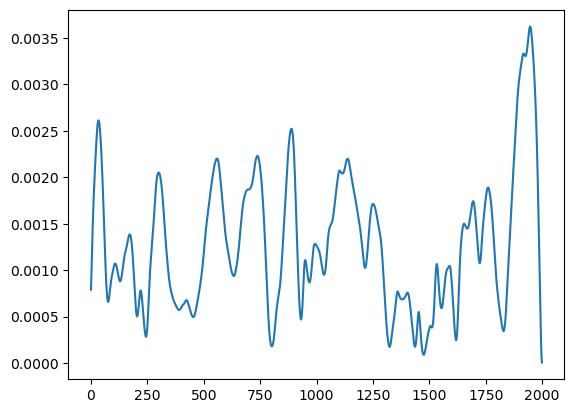

In [ ]:
filtered_velocity = ff.Filter_KIN(arr[~mask])
plt.plot(filtered_velocity)
# plt.plot(arr)

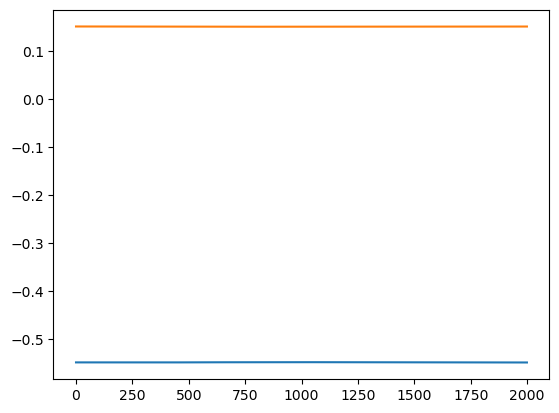

In [ ]:
arr1 = data[start_time:end_time]['Left_HandX'].to_numpy()
arr2 = data[start_time:end_time]['Left_HandY'].to_numpy()
arr = np.sqrt(arr1**2 + arr2**2)
plt.plot(arr1) 
plt.plot(arr2)
# plt.ylim(0.568,0.58)